### Lingering questions
- confusion matrix intuition
- meaning of precision / recall performance measures
  - **Precision**: out of all positive predictions, how many were accurate
      - you can pretty much create a classifier with any precision you want. just set the threshold high enough. but your recall will suffer.
      - True positives / (True positives + false positives)
  - **Recall**: out of all instances that were supposed to be labeled positive, how many were?
      - True positives / (True positives + false negatives)

### Notes
- OvO (One vs One) - training a binary classifier on every pair of digits
- OvA (One vs All) - training a binary classifier on only 0s, only 1s, etc.. (like we did with 5s). So we train a 1 detector, 4 detector, etc.. then select the detector with the highest score for a given image as the prediction.

Figure 3-3. Decision threshold and precision/recall tradeoff
![Figure 3-3. Decision threshold and precision/recall tradeoff](images/3-3.png)

In [1]:
import numpy as np
import os
import warnings

np.random.seed(42)
warnings.filterwarnings(action="ignore", category=FutureWarning)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

/Users/henryehly/src/handson-ml/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/henryehly/src/handson-ml/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

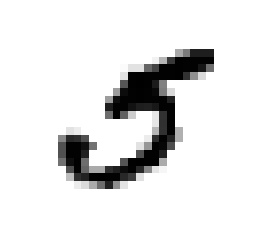

In [6]:
sample_5 = X[36000]
sample_5_image = np.reshape(sample_5, (28, 28))
plt.imshow(sample_5_image, cmap=matplotlib.cm.binary)
plt.axis('off')
plt.show()

In [7]:
y[36000]

5.0

In [8]:
# test and train sets alreaady split by sklearn
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# shuffle to make sure that when we do cross validation, each fold contains all the numbers
# np.random.permutation takes an int (treated as a range from 0~) or a list and shuffles it
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

In [9]:
# trying to just identify a single digit for now
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [10]:
from sklearn.linear_model import SGDClassifier

# 'stochastic' means 'random determined'
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([sample_5])

array([ True])

# Performance Measures

In [12]:
# cross validation is one way to measure the accuracy of a model
# K-fold CV does the following
# 1. splits the training set into a given number (K) of folds
# 2. trains a model on the training fold data, and makes predictions on the fold test data
# 3. (?)evaluates those predictions on each fold using a model trained on the other folds
from sklearn.model_selection import cross_val_score

# the 'accuracy' scoring is the ratio of correct predictions
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9502 , 0.96565, 0.96495])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
# Because only 10% of the images are 5s, we can get 90% accuracy just by guessing 'not 5' every time.
# Accuracy scoring is generally not the preferred way to measure classifier performance.
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90715, 0.9128 ])

In [15]:
# Custom implementation of cross validation with accuracy scoring
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X=X_train_folds, y=y_train_folds)
    y_pred = clone_clf.predict(X=X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


# Confusion Matrix

In [16]:
# to compute the confusion matrix, you need a set of predictions to compare to the target values
# cross_val_predict returns the predictions (not the scores) from the cross validation
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [17]:
from sklearn.metrics import confusion_matrix

# a row represents an actual class
# a column represents a predicted class
# 1307 wrongly classified as 5s
# 1077 wrongly classified as non-5s
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

In [18]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [19]:
# another metric is the accuracy of the positive predictions (call the "precision classifier")
# it is used alongside "recall" which is the ratio of positive instances that are correctly detected by the classifier
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print(precision) # 4344 / (4344 + 1307)
print(recall)    # 4344 / (4344 + 1077)

0.7687135020350381
0.801328168234643


The harmonic mean of precision and recall gives you the F1 score, which is commonly used to combine precision and recall.

$
F_1=\dfrac{2}{ \dfrac{1}{precision} + \dfrac{1}{recall} }
$

In [20]:
from sklearn.metrics import f1_score

# computing f1_score with sklearn
print(f1_score(y_train_5, y_train_pred))

# is the same as the following
print(2 * (precision * recall) / (precision + recall))

0.7846820809248555
0.7846820809248555


In [21]:
# try adjusting the threshold ourselves
# decision_function returns a score for each instance
# and lets us make a prediction with any threshold we want
# based on that score
y_scores = sgd_clf.decision_function([sample_5])
y_scores

array([161855.74572176])

In [22]:
threshold = 0
y_sample_5_pred = (y_scores > threshold)
y_sample_5_pred

array([ True])

In [23]:
# raising the threshold decreases recall
# when the threshold was lower, the 5 was predicted correctly
# but when we raised the threshold, the 5 was missed
threshold = 200000
y_sample_5_pred = (y_scores > threshold)
y_sample_5_pred

array([False])

In [24]:
# here is how we can get all the decision function scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([ -434076.49813641, -1825667.15281624,  -767086.76186905, ...,
        -867191.25267994,  -565357.11420164,  -366599.16018198])

In [25]:
from sklearn.metrics import precision_recall_curve

# this will give us what we need to visualize the 
# relationship between precision, recall & threshold
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

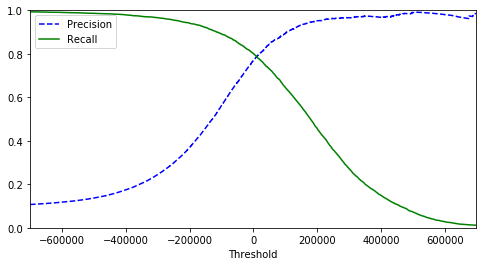

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plt.xlim([-700000, 700000])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [27]:
# let's say we want to aim for 90% precision
# if you look at the graph above, it looks like we should set our threshold
# at around 70,000
y_train_pred_90 = (y_scores > 70000)

In [28]:
precision_score(y_true=y_train_5, y_pred=y_train_pred_90)

0.8659205116491548

In [29]:
recall_score(y_true=y_train_5, y_pred=y_train_pred_90)

0.6993174691016417

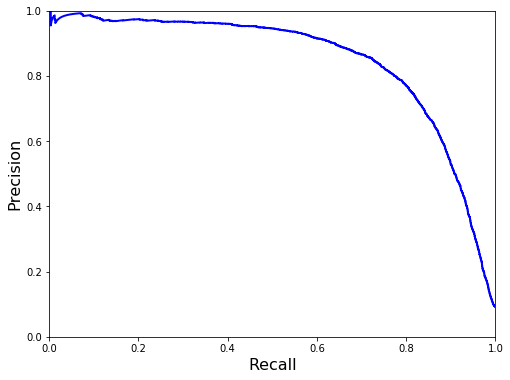

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# The ROC Curve

In [31]:
# receiver operating characteristic (ROC) curve is common tool used with binary classifiers
# it plots the 'true positive rate' (recall) against the 'false positive rate'
# FPR = negative instances that are incorrectly classified as positive (equal to 1 - TNR)
# TNR (also called 'specificity') = ratio of negative instances correctly classified as negative
# so, ROC plots 'sensitivity (ie Recall)' versus (1 - specificity)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.99446674, 0.99446674,
        1.        ]),
 array([0.00000000e+00, 1.84467810e-04, 3.87382402e-03, ...,
        9.99815532e-01, 1.00000000e+00, 1.00000000e+00]),
 array([ 1002863.09359785,  1002862.09359785,   788024.40783823, ...,
        -1612415.64410228, -1613405.71147769, -2922518.84137436]))

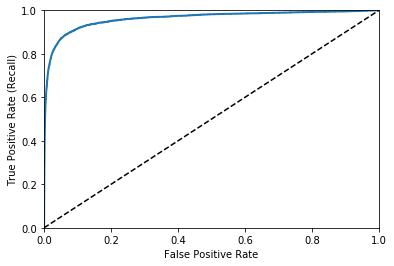

In [32]:
# you should use PR curve when the positive class is rare, 
# or you care more about the false positives than the false negatives;
# otherwise, use the ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    # this line shows what an ROC curve of a completely random ROC classifier would produce
    # good classifiers stay as far away from this line as possible (to the top left)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')

plot_roc_curve(fpr, tpr)
plt.show()

In [33]:
# AUC stands for 'area under the curve'
# a perfect classifier score would be 1
# a purely random classifier score would be 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967156

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

# RandomForestClassifier doesn't have 'decision_function';
# instead it uses 'predict_proba' which returns the probability
# that an instance belongs to the given class
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

In [35]:
y_probas_forest

array([[1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [36]:
# probability of the positive class 
# (because we need the scores to plot ROC)
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest

array([0. , 0.1, 0. , ..., 0. , 0. , 0. ])

In [37]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
fpr_forest, tpr_forest, thresholds_forest

(array([0.00000000e+00, 0.00000000e+00, 3.66441305e-05, 2.01542718e-04,
        5.49661958e-04, 1.22757837e-03, 3.05978490e-03, 6.77916415e-03,
        1.67463677e-02, 4.42294655e-02, 1.63066381e-01, 1.00000000e+00]),
 array([0.        , 0.2802066 , 0.49345139, 0.64655968, 0.75428888,
        0.82826047, 0.882494  , 0.92510607, 0.95609666, 0.97767939,
        0.99354363, 1.        ]),
 array([2. , 1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ]))

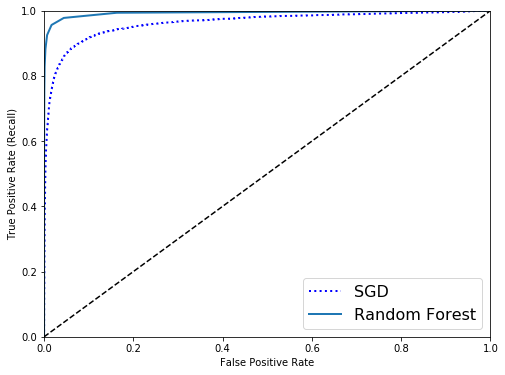

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', linewidth=2, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right', fontsize=16)
plt.show()

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

As you can see, the Random Forest curve looks better than the SGD curve. It's a lot closer to the top left corner. The ROC AUC score is also better.

In [40]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
y_train_pred_forest

array([False, False, False, ..., False, False, False])

In [41]:
precision = precision_score(y_train_5, y_train_pred_forest)
recall = recall_score(y_train_5, y_train_pred_forest)
precision, recall

(0.9852973447443494, 0.8282604685482383)

# Multiclass Classification

In [42]:
sgd_clf.fit(X_train, y_train) # using y_train (not y_train_5)
sgd_clf.predict([sample_5])

array([5.])

In [43]:
# Under the hood, scikit-learn actually did OvA and trained 10 binary
# classifiers and selected the one with the highest score for the image.
# You can see the scores here! (Look at index 5!)
sample_5_scores = sgd_clf.decision_function([sample_5])
sample_5_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [44]:
np.argmax(sample_5_scores)

5

In [45]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [46]:
sgd_clf.classes_[5]

5.0

In [47]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([sample_5])

array([5.])

In [49]:
# Random forest does not use OvA or OvO because it classifiest directly
# into multiple classes. You can see the probabilities assigned for each
# class for a given instance.
# Notice how the probability at index 5 is the highest
# the random forest classifier model estimates an 80% probability its' a 5
forest_clf.predict_proba([sample_5])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.84063187, 0.84899245, 0.86652998])

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

X_train[0], X_train_scaled[0]

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 189, 253,
         60,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        232, 252, 226,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [53]:
# Simply scaling the values like we did in Chapter 2 raises our accuracy to 90%
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.91011798, 0.90874544, 0.906636  ])

# Error Analysis

In [56]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
y_train[:5], y_train_pred[:5]

(array([1., 6., 6., 1., 1.]), array([1., 6., 6., 1., 1.]))

In [57]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

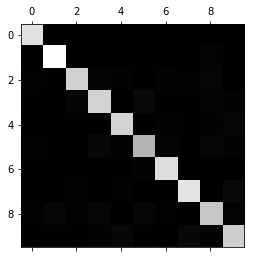

In [60]:
# We can look at the confusion matrix with matplotlib
# This plot looks good because most images are on the main diagonal axis
# meaning they were classified correctly
# Notice how 5 is slightly darker. This could be because there are less 5s in the dataset
# or the classifier does not perform as well on 5s
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [61]:
# Let's focus on the error rate
# To get the error rate, divide each value in the confusion matrix
# by the number of images in the corresponding class (value count)
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [68]:
import pandas as pd
pd.Series(y_train).value_counts(sort=False)

0.0    5923
1.0    6742
2.0    5958
4.0    5842
8.0    5851
9.0    5949
5.0    5421
3.0    6131
6.0    5918
7.0    6265
dtype: int64

In [69]:
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.66570994e-01, 5.06500084e-04, 4.05200068e-03, 1.51950025e-03,
        1.68833361e-03, 8.27283471e-03, 8.44166807e-03, 1.68833361e-03,
        6.58450110e-03, 6.75333446e-04],
       [2.96647879e-04, 9.63067339e-01, 6.37792940e-03, 3.70809849e-03,
        1.03826758e-03, 5.93295758e-03, 7.41619697e-04, 1.48323939e-03,
        1.61673094e-02, 1.18659152e-03],
       [8.55991944e-03, 6.88150386e-03, 8.93084928e-01, 1.74555220e-02,
        1.49378986e-02, 4.36388050e-03, 1.46022155e-02, 1.00704935e-02,
        2.78616986e-02, 2.18194025e-03],
       [7.66595988e-03, 7.50285435e-03, 2.29978796e-02, 8.71309737e-01,
        1.63105529e-04, 3.76773773e-02, 6.52422117e-03, 8.15527646e-03,
        2.29978796e-02, 1.50057087e-02],
       [3.25231085e-03, 4.96405341e-03, 7.01814447e-03, 1.71174255e-03,
        9.18521054e-01, 1.54056830e-03, 9.58575830e-03, 6.33344745e-03,
        1.47209860e-02, 3.23519343e-02],
       [1.34661502e-02, 8.30105147e-03, 6.64084117e-03, 3.56022874e-02,
   

In [71]:
# https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.fill_diagonal.html
# >>> a = np.zeros((3, 3, 3), int)
# >>> a
# array([[[0, 0, 0],
#         [0, 0, 0],
#         [0, 0, 0]],

#        [[0, 0, 0],
#         [0, 0, 0],
#         [0, 0, 0]],

#        [[0, 0, 0],
#         [0, 0, 0],
#         [0, 0, 0]]])
# >>> np.fill_diagonal(a, 4)
# >>> a
# array([[[4, 0, 0],
#         [0, 0, 0],
#         [0, 0, 0]],

#        [[0, 0, 0],
#         [0, 4, 0],
#         [0, 0, 0]],

#        [[0, 0, 0],
#         [0, 0, 0],
#         [0, 0, 4]]])
np.fill_diagonal(norm_conf_mx, 0)
norm_conf_mx

array([[0.        , 0.0005065 , 0.004052  , 0.0015195 , 0.00168833,
        0.00827283, 0.00844167, 0.00168833, 0.0065845 , 0.00067533],
       [0.00029665, 0.        , 0.00637793, 0.0037081 , 0.00103827,
        0.00593296, 0.00074162, 0.00148324, 0.01616731, 0.00118659],
       [0.00855992, 0.0068815 , 0.        , 0.01745552, 0.0149379 ,
        0.00436388, 0.01460222, 0.01007049, 0.0278617 , 0.00218194],
       [0.00766596, 0.00750285, 0.02299788, 0.        , 0.00016311,
        0.03767738, 0.00652422, 0.00815528, 0.02299788, 0.01500571],
       [0.00325231, 0.00496405, 0.00701814, 0.00171174, 0.        ,
        0.00154057, 0.00958576, 0.00633345, 0.01472099, 0.03235193],
       [0.01346615, 0.00830105, 0.00664084, 0.03560229, 0.01180594,
        0.        , 0.02047593, 0.00553403, 0.03560229, 0.01733997],
       [0.0049003 , 0.00574518, 0.00743494, 0.00033795, 0.00709699,
        0.01436296, 0.        , 0.00168976, 0.00760392, 0.        ],
       [0.00399042, 0.00383081, 0.0118116

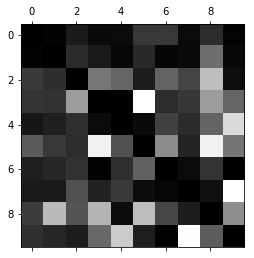

In [72]:
# Rows represent actual classes
# Columns represent predicted classes
# 
# Look at row 5, column 8. It is white.
# This means there are quite a few 5s that are classified as 8s
# The opposite is not always true however (row 8 col 5 is not as bright)
#
# 3s and 5s looks like they're confused a lot too
#
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [73]:
# Taken directly from
# https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

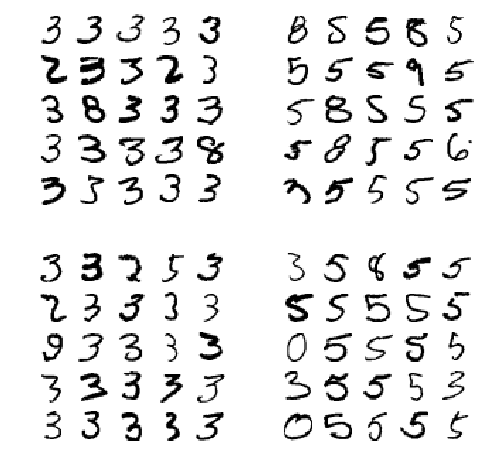

In [91]:
# Let's analyze individual errors
# TL(221): actual(3) pred(3)
# TR(222): actual(3) pred(5)
# BL(223): actual(5) pred(3)
# BR(224): actual(5) pred(5)

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel Classification

Outputting multiple binary labels (class X yes/no) for each instance is called "Multilabel Classification."
The example used in the book is identifying multiple people in a single photo.
Instead of labeling 1 person for each photo, we want our classifier to output multiple
people for each photo.

Ex. if we trained a classifier to recognize Alice, Bob and Charlie, and
only Alice and Charlie are in the instance photo, the output should be `[1, 0, 1]`

In [92]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

# Create 2 target labels for each image
# 1. whether digit is large (7, 8 or 9)
# 2. whether digit is odd
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [93]:
# Not all classifiers support multilabel classification,
# but KNeighborsClassifier does
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [94]:
# Now feed the classifier an instance, and see how it outputs 2 binary labels!
# 1. 5 is not large (correct!)
# 2. 5 is an odd number (correct!)
knn_clf.predict([sample_5])

array([[False,  True]])